In [1]:
import pandas as pd

In [6]:
df = pd.read_csv("./co2.csv", index_col=0)

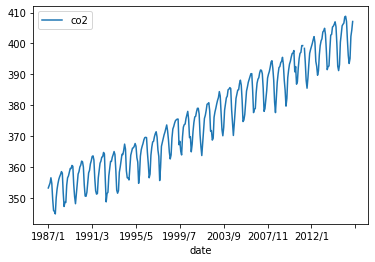

In [7]:
df.plot()